In [3]:
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from celluloid import Camera
from IPython.display import HTML
import collections.abc
from matplotlib.gridspec import GridSpec
import exorim as exo
import xara
import pickle
import matplotlib
from numpy.fft import fft2, ifft2
%matplotlib inline

In [4]:
os.chdir("..")
basedir = os.getcwd()
basedir

'/home/alexandre/Desktop/Projects/ExoRIM'

In [49]:
# id = "20-08-20_14-19-28"
# id = "20-08-25_16-47-24"
# id = "20-10-01_11-12-26"
# id = "21-03-04_15-50-12"
# id = "21-03-28_14-59-25"
# id = "21-03-28_15-47-46"
# id = "21-03-28_16-39-39"
# id = "21-03-28_16-56-08"
# id = "21-03-28_17-04-48"
# id = "21-03-31_12-26-11"
# id = "21-03-31_12-39-22"
# id = "21-04-01_10-37-33" #with adam (likelihood grad)
# id = "21-05-10_10-03-33"
id = "21-05-10_10-16-03"

results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")

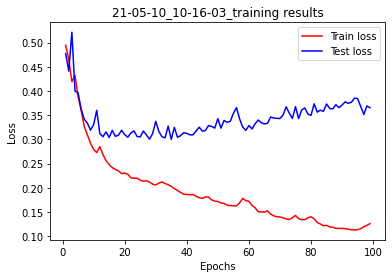

In [50]:
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.yscale("log")
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [51]:
def gaussian_filter(pixel_scale, resolution, pixels):
#     size = min(int(3 * resolution / pixel), pixels) 
    sigma = resolution / 2
    size = pixels
#     print(f"kernel size = {size}")
    x = (np.arange(size) - size//2)* pixel_scale
    xx, yy = np.meshgrid(x, x) 
    rho = np.sqrt(xx**2 + yy**2)
    out = np.zeros((size, size))
    out += np.exp(-rho**2 / sigma**2) / np.sqrt(2 * np.pi)/sigma
    return out
    
def fft_convolve2d(x,y):
    N = x.shape[0]
    n = N//2
    pad = int(2*N)
    pads = (pad, pad)
    return np.abs(ifft2(fft2(x, pads) * fft2(y, pads)))[n:-n, n:-n]

In [52]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(results_dir, "output*")):
    name = os.path.split(file)[-1]
    if name[-3:] == "png":
        epoch = int(name[7:10])
        index = int(name[11:15])
        step = int(name[16:18])
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
            update(images, {index: {epoch : {step: im}}})
    elif name[-3:] == "txt":
        epoch = int(name[7:11])
        index = int(name[12:16])
        step = int(name[17:19])
        im = np.loadtxt(file)
        update(images, {index: {epoch : {step: im}}})
images.keys()

dict_keys([20, 80, 60, 40])

In [53]:
log_grad = {}
for file in glob.glob(os.path.join(results_dir, "grad_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[5:9])
    index = int(name[10:14])
    step = int(name[15:17])
    g = np.loadtxt(file)
    update(log_grad, {index: {epoch : {step: g}}})
with open(os.path.join(results_dir, "grad_and_weights.pickle"), "rb") as f:
    grad_and_weights = pickle.load(f)

In [54]:
ground_truth = {}
for file in glob.glob(os.path.join(train_data_dir, "image[0-9]*")):
    name = os.path.split(file)[-1]
    index = int(name[-7:-4])
    if name[-3:] == "png":
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
            ground_truth[index] = im
    elif name[-3:] == "txt":
        update(ground_truth, {index: np.loadtxt(file)})
ground_truth.keys()

dict_keys([0, 60, 40, 20])

In [62]:
%%capture

index = 40
# index = 50
step = 7
# step = 11
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    im = selected_image[key][step]
    plt.imshow(im, cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "output.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

In [63]:
%%capture
fig = plt.figure()
cam = Camera(fig)
for key in sorted(list(selected_image.keys())):
    plt.imshow(np.abs((ground_truth[index] - selected_image[key][step])), cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "residual.mp4"), writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [64]:
%%capture

fig = plt.figure()
cam = Camera(fig)
selected_grad = log_grad[index]
for key in sorted(list(selected_grad.keys())):
    plt.imshow(selected_grad[key][step])
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "log_likelihood_grad.mp4"), writer="ffmpeg")
anim3 = HTML(animation.to_html5_video())

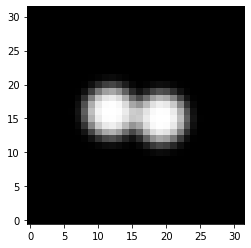

In [72]:
fig, axs = plt.subplots(1, 1)
axs.imshow(ground_truth[index+20], cmap="gray")
plt.savefig(os.path.join(results_dir, "ground_truth.png"))

In [66]:
# Output
anim1

In [67]:
# Residual
anim2

In [68]:
# likelihood grad
anim3

Text(0, 0.5, 'Resiudal')

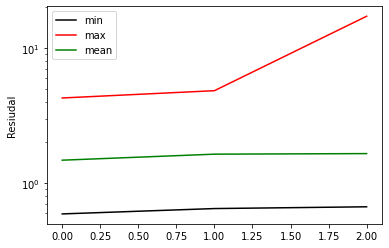

In [17]:
res_min = []
res_max = []
res_mean = []
for key in sorted(list(selected_image.keys())):
    res_min.append(np.abs((ground_truth[index][0] - selected_image[key][step])).min())
    res_max.append(np.abs((ground_truth[index][0] - selected_image[key][step])).max())
    res_mean.append(np.abs((ground_truth[index][0] - selected_image[key][step])).mean())


plt.plot(res_min, "k-", label="min")
plt.plot(res_max, "r-", label="max")
plt.plot(res_mean, "g-", label="mean")
plt.legend()
plt.yscale("log")
plt.ylabel("Resiudal")

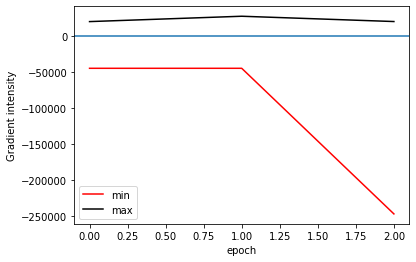

In [18]:
fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_grad.keys())):
    mi.append(selected_grad[key][step].min())
    ma.append(selected_grad[key][step].max())
plt.axhline(0)
plt.plot(mi, "r-", label="min")
plt.plot(ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Gradient intensity")
plt.legend()
plt.show()

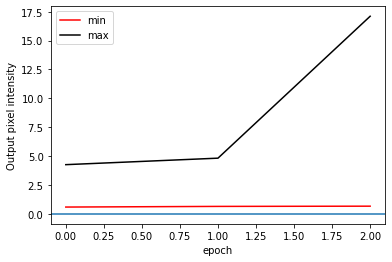

In [19]:
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(selected_image[key][step].min())
    ma.append(selected_image[key][step].max())
plt.axhline(0)
plt.plot(mi, "r-", label="min")
plt.plot(ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Output pixel intensity")
plt.legend()
plt.show()
# selected_image[1][2].max()

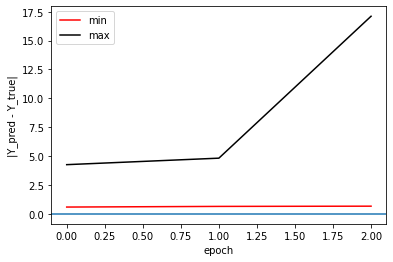

In [20]:

fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(np.abs(selected_image[key][step] - ground_truth[index][0]).min())
    ma.append(np.abs(selected_image[key][step] - ground_truth[index][0]).max())
plt.axhline(0)
plt.plot(mi, "r-", label="min")
plt.plot(ma, "k-", label="max")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("|Y_pred - Y_true|")
plt.show()

In [21]:
batch = 0
# map_layer_to_depth = {
#     "model/Conv_Downsample": 0,
#     "model/Conv_1": 1,
#     "model/conv_gru/conv2d": 2,
#     "model/conv_gru/conv2d_1": 3,
#     "model/conv_gru/conv2d_2": 4,
#     "model/conv_gru_1/conv2d_3": 5,
#     "model/conv_gru_1/conv2d_4": 6,
#     "model/conv_gru_1/conv2d_5": 7,
#     "model/Conv_Fraction_Stride": 8,
#     "model/TConv_1": 9
# }
map_layer_to_depth = {
    "RIM/Conv_Downsample": 0,
    "RIM/Conv_1": 1,
    "RIM/Conv_2": 2,
    "RIM/conv_gru/conv2d": 3,
    "RIM/conv_gru/conv2d_1": 4,
    "RIM/conv_gru/conv2d_2": 5,
    "RIM/conv_gru_1/conv2d_3": 6,
    "RIM/conv_gru_1/conv2d_4": 7,
    "RIM/conv_gru_1/conv2d_5": 8,
    "RIM/Conv_Fraction_Stride": 9,
    "RIM/TConv_1": 10,
    "RIM/TConv_2": 11
}
inv_map = {v: k for k, v in map_layer_to_depth.items()}

kernel_weight_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_max = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_min = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
for layer_name in grad_and_weights.keys():
    if "kernel" in layer_name:
        layer = layer_name[:-len("/kernel:0")]
        depth = map_layer_to_depth[layer]
        for epoch, d in grad_and_weights[layer_name].items():
            kernel_weight_mean[depth].append(d[batch]["weight_mean"])
            kernel_weight_var[depth].append(d[batch]["weight_var"])
            kernel_grad_mean[depth].append(d[batch]["grad_mean"])
            kernel_grad_var[depth].append(d[batch]["grad_var"])
            kernel_weight_max[depth].append(d[batch]["weight_max"])
            kernel_weight_min[depth].append(d[batch]["weight_min"])
cmap = matplotlib.cm.get_cmap("tab10")
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_weight_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight mean")
plt.savefig(os.path.join(results_dir, "weight_mean.png"))
# name: epoch: batch: stats

KeyError: 'modelv1/DownsampleConv1'

In [22]:
for depth, data in enumerate(kernel_weight_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight variance")
plt.savefig(os.path.join(results_dir, "weight_var.png"))

NameError: name 'cmap' is not defined

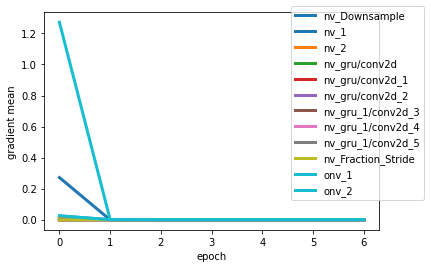

In [31]:
# cmap = matplotlib.cm.get_cmap("seismic")
# norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_grad_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient mean")
# plt.yscale("log")
plt.savefig(os.path.join(results_dir, "backpropgrad_mean.png"))

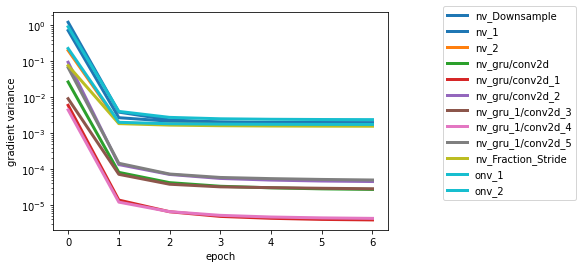

In [32]:
for depth, data in enumerate(kernel_grad_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient variance")
plt.yscale("log")
plt.savefig(os.path.join(results_dir, "backpropgrad_var.png"))

In [98]:
np.random.seed(42)
N = 50
wavel = 0.5e-6
pad = 0
pix = 32 + 0*pad
L = 6
plate_scale = 3.2
m = 1
SNR = 100
circle_mask = np.zeros((N, 2))
for i in range(N):
    circle_mask[i, 0] = (L + np.random.normal(0, m)) * np.cos(2 * np.pi * i / N)
    circle_mask[i, 1] = (L + np.random.normal(0, m)) * np.sin(2 * np.pi * i / N)
random_mask = np.random.normal(size=(N, 2))
image_coords = np.arange(pix) - pix / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho_squared = (xx - 5) ** 2 + (yy) ** 2
image += rho_squared == 0
rho_squared = (xx + 5) ** 2 + (yy) ** 2
image += np.exp(rho_squared / 5**2)
im = ground_truth[index] #np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# im = np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# plt.imshow(image, cmap="gray")
# baselines = exo.operators.Baselines(mask_coordinates=circle_mask)
# cpo = exo.operators.phase_closure_operator(baselines)
# dftm = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale)
# dftm_i = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale, inv=True)
# m2pix = exo.definitions.mas2rad(plate_scale) * pix / wavel
# phys = PhysicalModel(circle_mask, hyperparameters["pixels"], visibility_noise=1e-3, cp_noise=1e-5, m2pix=m2pix)
phys = exo.physical_model.PhysicalModel(pix, circle_mask, wavel, plate_scale, SNR)
pad2 = -pad if pad != 0 else None 
forward = phys.forward(np.reshape(im, [-1, pix, pix, 1]))
reconstructed_image = np.dot(phys.A_adjoint, forward[0, :phys.p].numpy())
plt.imshow(np.reshape(np.abs(reconstructed_image), [pix, pix])[pad:pad2, pad:pad2], cmap="gray")
print(np.abs(reconstructed_image).max())
print(tf.math.reduce_logsumexp(np.abs(reconstructed_image)))
print(np.abs(reconstructed_image).min())
plt.savefig(os.path.join(results_dir, "dirty_image.png"))

1225 distinct baselines found. Mask has 0 redundant baselines
There are 1176 independant closure phases


ValueError: cannot reshape array of size 1 into shape (32,32,1)

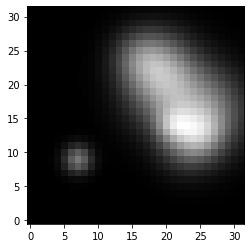

In [131]:
plt.imshow(im, cmap="gray")

In [132]:
b = np.sqrt(baselines.UVC[:, 0]**2 + baselines.UVC[:, 1]**2)
bx = baselines.UVC[:, 0]
by = baselines.UVC[:, 1]
xara.core.rad2mas(wavel/2/b.max())
plt.plot(b, np.abs(forward[0, :phys.p])/np.pi, "k.")
plt.ylabel("Visibility amplitude")
plt.xlabel("Baseline")

NameError: name 'baselines' is not defined

In [ ]:
m2pix = exo.definitions.mas2rad(plate_scale) * 32 / wavel
1.22 * 12/m2pix/2/np.pi

In [ ]:
basel = np.sqrt(phys.baselines.UVC[:, 0]**2 + phys.baselines.UVC[:, 1]**2)
basel.max()